In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import boto3
import os

from models import MobileNetV3, ViT
from data_preparation import CreateDataset, load_images_and_labels, encode_labels, create_data_augmentation
from trainer import evaluate_model, plot_losses
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import multiprocessing

num_workers = multiprocessing.cpu_count()

batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_num_threads(num_workers)

print(f"Using {num_workers} CPU cores for training")
print(f"Device is {device}")

/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using 32 CPU cores for training
Device is cuda


In [2]:
data = "ck"

bucket_name = 'thesissagemakerbucket'
train_path = f'{data}/train'
test_path = f'{data}/test'

X_train, y_train = load_images_and_labels(bucket_name, train_path)
X_test, y_test = load_images_and_labels(bucket_name, test_path)

In [3]:
X = X_train + X_test
y = y_train + y_test

# split into training and testing data using sklearn
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X, y,
                                                    test_size=0.5,
                                                    random_state=42)

X_test, X_val, y_test, y_val = train_test_split(X_test_and_val,
                                                y_test_and_val,
                                                test_size=0.5,
                                                random_state=42)

In [4]:
# Encode labels to integers
label_encoder, y_train, y_val, y_test = encode_labels(y_train, y_val, y_test)

In [5]:
transform = create_data_augmentation()

train_dataset = CreateDataset(X_train, y_train, transform=transform)
test_dataset = CreateDataset(X_test, y_test, transform=transform)
val_dataset = CreateDataset(X_val, y_val, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


In [6]:
teacher_model = ViT(num_labels=len(label_encoder.classes_))

model_path = f'vit_{data}_best_model.pt'

teacher_model.load_state_dict(torch.load(model_path, weights_only=False))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [7]:
student_model = MobileNetV3(num_labels=len(label_encoder.classes_))

/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# If multiple GPUs are available, use DataParallel
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    teacher_model = torch.nn.DataParallel(teacher_model)
    student_model = torch.nn.DataParallel(student_model)

teacher_model = teacher_model.to(device)
student_model = student_model.to(device)

In [9]:
def train_knowledge_distillation(teacher,
                                 student,
                                 train_loader,
                                 val_loader,
                                 epochs,
                                 learning_rate,
                                 T,
                                 soft_target_loss_weight,
                                 ce_loss_weight,
                                 device,
                                 patience=5):

    ce_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.eval()
    student.train()

    best_val_loss = float('inf')
    epochs_no_improve = 0

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        student.train()

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.no_grad():
                teacher_logits = teacher(inputs).logits

            student_logits = student(inputs)

            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

            soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)

            label_loss = ce_loss(student_logits, labels)

            loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            del inputs, labels, student_logits, teacher_logits, loss
            torch.cuda.empty_cache()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        student.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation"):
                inputs, labels = inputs.to(device), labels.to(device)

                student_logits = student(inputs)

                label_loss = ce_loss(student_logits, labels)
                val_loss += label_loss.item()

                # Deleting only the unnecessary variables
                del inputs, labels, student_logits
                torch.cuda.empty_cache()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            #torch.save(student.state_dict(), f'model/student_{data}_best_model.pt')
            best_model = student
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    return best_model, train_losses, val_losses


best_model, train_loss, val_loss = train_knowledge_distillation(
                                            teacher=teacher_model,
                                            student=student_model,
                                            train_loader=train_loader,
                                            val_loader=test_loader,
                                            epochs=500,
                                            learning_rate=0.0001,
                                            T=8,
                                            soft_target_loss_weight=0.25,
                                            ce_loss_weight=0.75,
                                            device=device,
                                            patience=10
                                        )

Epoch 1/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  4.88it/s]


Epoch 1/500, Train Loss: 2.0607, Validation Loss: 1.8387


Epoch 2/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.36it/s]


Epoch 2/500, Train Loss: 1.7631, Validation Loss: 1.6415


Epoch 3/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.29it/s]


Epoch 3/500, Train Loss: 1.5276, Validation Loss: 1.5370


Epoch 4/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.11it/s]


Epoch 4/500, Train Loss: 1.2823, Validation Loss: 1.4143


Epoch 5/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.21it/s]


Epoch 5/500, Train Loss: 1.1000, Validation Loss: 1.3242


Epoch 6/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.40it/s]


Epoch 6/500, Train Loss: 0.9298, Validation Loss: 1.2914


Epoch 7/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.28it/s]


Epoch 7/500, Train Loss: 0.7950, Validation Loss: 1.2102


Epoch 8/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.09it/s]


Epoch 8/500, Train Loss: 0.7176, Validation Loss: 1.0827


Epoch 9/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.27it/s]


Epoch 9/500, Train Loss: 0.6056, Validation Loss: 1.0428


Epoch 10/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  4.92it/s]


Epoch 10/500, Train Loss: 0.5564, Validation Loss: 1.0543


Epoch 11/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.07it/s]


Epoch 11/500, Train Loss: 0.4655, Validation Loss: 0.9918


Epoch 12/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  4.97it/s]


Epoch 12/500, Train Loss: 0.4108, Validation Loss: 0.9914


Epoch 13/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.08it/s]


Epoch 13/500, Train Loss: 0.3863, Validation Loss: 0.9205


Epoch 14/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.05it/s]


Epoch 14/500, Train Loss: 0.3413, Validation Loss: 0.9133


Epoch 15/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.04it/s]


Epoch 15/500, Train Loss: 0.3160, Validation Loss: 0.8328


Epoch 16/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.07it/s]


Epoch 16/500, Train Loss: 0.2652, Validation Loss: 0.8862


Epoch 17/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.26it/s]


Epoch 17/500, Train Loss: 0.2636, Validation Loss: 0.8137


Epoch 18/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.24it/s]


Epoch 18/500, Train Loss: 0.2390, Validation Loss: 0.7445


Epoch 19/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


Epoch 19/500, Train Loss: 0.2038, Validation Loss: 0.8232


Epoch 20/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


Epoch 20/500, Train Loss: 0.1977, Validation Loss: 0.7343


Epoch 21/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.42it/s]


Epoch 21/500, Train Loss: 0.1713, Validation Loss: 0.7405


Epoch 22/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.16it/s]


Epoch 22/500, Train Loss: 0.1698, Validation Loss: 0.6886


Epoch 23/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.42it/s]


Epoch 23/500, Train Loss: 0.1583, Validation Loss: 0.6541


Epoch 24/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.29it/s]


Epoch 24/500, Train Loss: 0.1537, Validation Loss: 0.6573


Epoch 25/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.32it/s]


Epoch 25/500, Train Loss: 0.1522, Validation Loss: 0.5661


Epoch 26/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.35it/s]


Epoch 26/500, Train Loss: 0.1366, Validation Loss: 0.5488


Epoch 27/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.25it/s]


Epoch 27/500, Train Loss: 0.1369, Validation Loss: 0.5228


Epoch 28/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  4.97it/s]


Epoch 28/500, Train Loss: 0.1190, Validation Loss: 0.5795


Epoch 29/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.37it/s]


Epoch 29/500, Train Loss: 0.1140, Validation Loss: 0.4496


Epoch 30/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.43it/s]


Epoch 30/500, Train Loss: 0.1115, Validation Loss: 0.4643


Epoch 31/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.29it/s]


Epoch 31/500, Train Loss: 0.1040, Validation Loss: 0.4313


Epoch 32/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.31it/s]


Epoch 32/500, Train Loss: 0.1050, Validation Loss: 0.3564


Epoch 33/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.30it/s]


Epoch 33/500, Train Loss: 0.1079, Validation Loss: 0.3040


Epoch 34/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.48it/s]


Epoch 34/500, Train Loss: 0.0987, Validation Loss: 0.3203


Epoch 35/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.23it/s]


Epoch 35/500, Train Loss: 0.0965, Validation Loss: 0.3339


Epoch 36/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.08it/s]


Epoch 36/500, Train Loss: 0.0973, Validation Loss: 0.2337


Epoch 37/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.37it/s]


Epoch 37/500, Train Loss: 0.0857, Validation Loss: 0.2216


Epoch 38/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.34it/s]


Epoch 38/500, Train Loss: 0.0859, Validation Loss: 0.2218


Epoch 39/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.31it/s]


Epoch 39/500, Train Loss: 0.0905, Validation Loss: 0.1975


Epoch 40/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.34it/s]


Epoch 40/500, Train Loss: 0.0941, Validation Loss: 0.1893


Epoch 41/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.10it/s]


Epoch 41/500, Train Loss: 0.0810, Validation Loss: 0.1755


Epoch 42/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.32it/s]


Epoch 42/500, Train Loss: 0.0784, Validation Loss: 0.2228


Epoch 43/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.18it/s]


Epoch 43/500, Train Loss: 0.0862, Validation Loss: 0.1534


Epoch 44/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.23it/s]


Epoch 44/500, Train Loss: 0.0735, Validation Loss: 0.1621


Epoch 45/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.15it/s]


Epoch 45/500, Train Loss: 0.0718, Validation Loss: 0.2034


Epoch 46/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.43it/s]


Epoch 46/500, Train Loss: 0.0728, Validation Loss: 0.1356


Epoch 47/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.24it/s]


Epoch 47/500, Train Loss: 0.0656, Validation Loss: 0.1524


Epoch 48/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.27it/s]


Epoch 48/500, Train Loss: 0.0670, Validation Loss: 0.1304


Epoch 49/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.22it/s]


Epoch 49/500, Train Loss: 0.0627, Validation Loss: 0.1132


Epoch 50/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.23it/s]


Epoch 50/500, Train Loss: 0.0714, Validation Loss: 0.1417


Epoch 51/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.34it/s]


Epoch 51/500, Train Loss: 0.0686, Validation Loss: 0.1310


Epoch 52/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.39it/s]


Epoch 52/500, Train Loss: 0.0656, Validation Loss: 0.1549


Epoch 53/500 - Validation: 100%|██████████| 8/8 [00:02<00:00,  3.88it/s]


Epoch 53/500, Train Loss: 0.0642, Validation Loss: 0.1246


Epoch 54/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.14it/s]


Epoch 54/500, Train Loss: 0.0588, Validation Loss: 0.1369


Epoch 55/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.07it/s]


Epoch 55/500, Train Loss: 0.0609, Validation Loss: 0.1285


Epoch 56/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.24it/s]


Epoch 56/500, Train Loss: 0.0618, Validation Loss: 0.1298


Epoch 57/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.08it/s]


Epoch 57/500, Train Loss: 0.0575, Validation Loss: 0.1468


Epoch 58/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.27it/s]


Epoch 58/500, Train Loss: 0.0586, Validation Loss: 0.1170


Epoch 59/500 - Validation: 100%|██████████| 8/8 [00:01<00:00,  5.36it/s]

Epoch 59/500, Train Loss: 0.0602, Validation Loss: 0.1235
Early stopping triggered after 59 epochs.


In [10]:
# Save the model to a local path
model_dir = f'{data}/models'

model_path = f'distilled_model_{data}_best_model.pt'
torch.save(best_model.state_dict(), model_path)

# Upload the model to S3
s3 = boto3.client('s3')
s3.upload_file(model_path, bucket_name, os.path.join(model_dir, model_path))

os.remove(model_path)

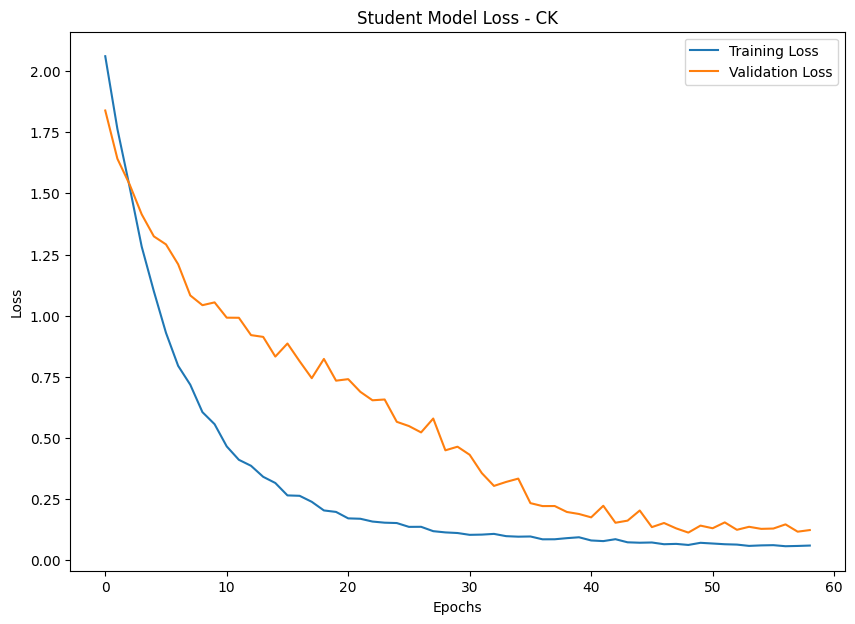

In [11]:
plot_losses(train_loss, val_loss, f'Student Model Loss - {data.upper()}')

In [12]:
best_model.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

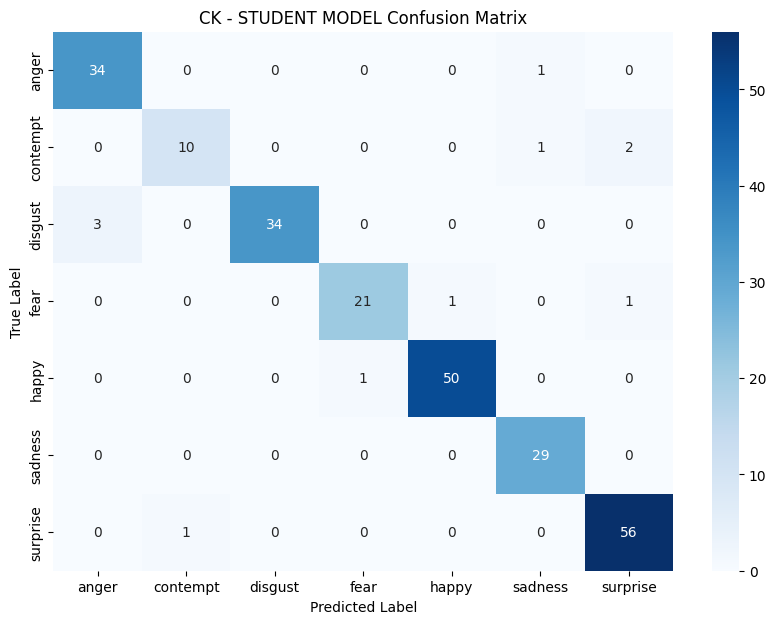

Test Accuracy: 0.9551
Precision: 0.9497
Recall: 0.9336
F1 Score: 0.9402
Classification Report:
               precision    recall  f1-score   support

       anger       0.92      0.97      0.94        35
    contempt       0.91      0.77      0.83        13
     disgust       1.00      0.92      0.96        37
        fear       0.95      0.91      0.93        23
       happy       0.98      0.98      0.98        51
     sadness       0.94      1.00      0.97        29
    surprise       0.95      0.98      0.97        57

    accuracy                           0.96       245
   macro avg       0.95      0.93      0.94       245
weighted avg       0.96      0.96      0.95       245



In [13]:
evaluate_model(best_model, 
               test_loader, 
               device, 
               data.upper()+" - Student Model",
               label_encoder=label_encoder)